In [ ]:
# necessary libraries
import glob
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.models as models

from IPython.display import display
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class VGG16Classifier(nn.Module):
    def __init__(self, num_classes=10, in_channels=3, num_conv_layers_to_use=None):
        super(VGG16Classifier, self).__init__()
        self.vgg16 = models.vgg16(weights='DEFAULT')

        # freeze all parameters initially
        for param in self.vgg16.parameters():
            param.requires_grad = False

        layers = {0:0, 1:2, 2:7, 3:14, 4:21, 5:28}
        for param in self.vgg16.features[layers[num_conv_layers_to_use]:].parameters():
             param.requires_grad = True


        # determine which convolutional layers to use
        if num_conv_layers_to_use is not None:
            self.features = nn.Sequential(*list(self.vgg16.features.children())[:num_conv_layers_to_use])
        else:
            self.features = self.vgg16.features

        dummy_input = torch.randn(1, in_channels, 224, 224) # assuming input image size 224x224
        with torch.no_grad():
            features_output_shape = self.features(dummy_input).shape
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        with torch.no_grad():
             flattened_size = torch.flatten(self.avgpool(self.features(dummy_input)), 1).shape[1]


        self.vgg16.classifier = nn.Sequential(
          nn.Linear(flattened_size, 4096),
          nn.ReLU(True),
          nn.Dropout(0.5),
          nn.Linear(4096, 4096),
          nn.ReLU(True),
          nn.Dropout(0.5),
          nn.Linear(4096, num_classes)
          )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.vgg16.classifier(x)
        return x

In [ ]:
output_base_dir = '/content/drive/My Drive/Frechette Lab/train_processed_dataset'
path_list = glob.glob('/content/drive/My Drive/Frechette Lab/train_dataset/*/*')

def preprocess(image_path, output, crop_height=224, crop_width=224):
    img = Image.open(image_path)
    width, height = img.size
    rows = height // crop_height
    cols = width // crop_width

    base_name = os.path.splitext(os.path.basename(image_path))[0]
    ext = os.path.splitext(os.path.basename(image_path))[1]

    class_name = os.path.basename(os.path.dirname(image_path))

    output_dir = os.path.join(output, class_name)
    os.makedirs(output_dir, exist_ok=True)

    for i in range(rows):
        for j in range(cols):
            left = j * crop_width
            upper = i * crop_height
            right = left + crop_width
            lower = upper + crop_height
            cropped_img = img.crop((left, upper, right, lower))
            new_filename = f"{base_name}_{i}_{j}{ext}"
            save_path = os.path.join(output_dir, new_filename)
            cropped_img.save(save_path)

for y in path_list:
    preprocess(y, output = output_base_dir, crop_height=224, crop_width=224)
    print(f"File {y} preprocessed")

File /content/drive/My Drive/Frechette Lab/train_dataset/PE_1um_PBSxHEX_no lipids_1hr/Copy of 130514.094.bmp preprocessed
File /content/drive/My Drive/Frechette Lab/train_dataset/PE_1um_PBSxHEX_no lipids_1hr/Copy of 0301-8-nolipids-1hr-scale0000.png preprocessed
File /content/drive/My Drive/Frechette Lab/train_dataset/PE_1um_PBSxHEX_no lipids_1hr/Copy of 133521.785.bmp preprocessed
File /content/drive/My Drive/Frechette Lab/train_dataset/PE_1um_PBSxHEX_no lipids_1hr/Copy of 140743.293.bmp preprocessed
File /content/drive/My Drive/Frechette Lab/train_dataset/PE_1um_PBSxHEX_no lipids_1hr/Copy of 171352.302.bmp preprocessed
File /content/drive/My Drive/Frechette Lab/train_dataset/PE_1um_PBSxHEX_no lipids_1hr/Copy of 164134.452.bmp preprocessed
File /content/drive/My Drive/Frechette Lab/train_dataset/PE_1um_PBSxHEX_no lipids_1hr/Copy of 164759.745.bmp preprocessed
File /content/drive/My Drive/Frechette Lab/train_dataset/PE_1um_PBSxHEX_no lipids_1hr/Copy of 164155.858.bmp preprocessed
File 

In [ ]:
"""
try:
    train_dataset = datasets.ImageFolder(root=output_base_dir, transform = transforms.ToTensor())
    print(f"Found {len(train_dataset)} images belonging to {len(train_dataset.classes)} classes.")

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    print("DataLoader created successfully.")

except Exception as e:
    print(f"Error creating ImageFolder dataset: {e}")
    print("Please ensure the directory structure in")
    print(f"{output_base_dir} follows the ImageFolder convention (subdirectories for classes).")
    print("Also check file permissions and that the directory exists.")
    """
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
try:
    train_dataset = datasets.ImageFolder(root='/content/drive/My Drive/Frechette Lab/train_dataset', transform=transform)
    print(f"Found {len(train_dataset)} images belonging to {len(train_dataset.classes)} classes.")
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    print("DataLoader created successfully.")

except Exception as e:
    print(f"Error creating ImageFolder dataset: {e}")
    print("Please ensure the directory structure in")
    print(f"{image_data_root} follows the ImageFolder convention (subdirectories for classes).")
    print("Also check file permissions and that the directory exists.")

Found 27 images belonging to 3 classes.
DataLoader created successfully.


In [ ]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

Successfully loaded model weights from /content/drive/My Drive/Frechette Lab/VGG16Classifier_weights.pt
Starting training...
Epoch 1, Loss: 1.2075, Train Accuracy: 37.04%
Epoch 2, Loss: 1.1408, Train Accuracy: 29.63%
Epoch 3, Loss: 1.1247, Train Accuracy: 29.63%
Epoch 4, Loss: 1.1057, Train Accuracy: 37.04%
Epoch 5, Loss: 1.1501, Train Accuracy: 37.04%
Epoch 6, Loss: 1.1342, Train Accuracy: 37.04%
Epoch 7, Loss: 1.0809, Train Accuracy: 37.04%
Epoch 8, Loss: 1.2142, Train Accuracy: 37.04%
Epoch 9, Loss: 1.1177, Train Accuracy: 37.04%
Epoch 10, Loss: 1.1313, Train Accuracy: 37.04%
Test Accuracy: 40.0
Training finished.
Successfully saved updated model weights to /content/drive/My Drive/Frechette Lab/VGG16Classifier_weights.pt


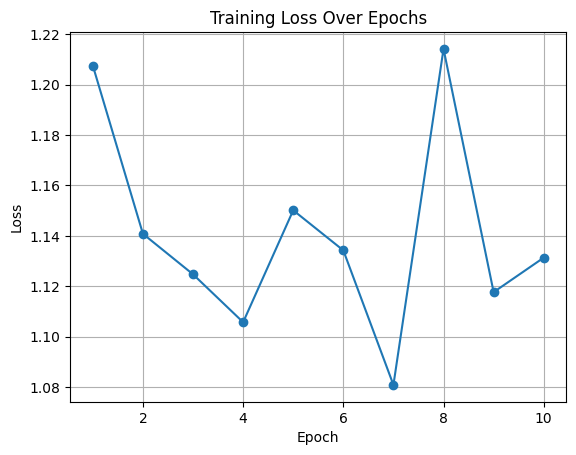

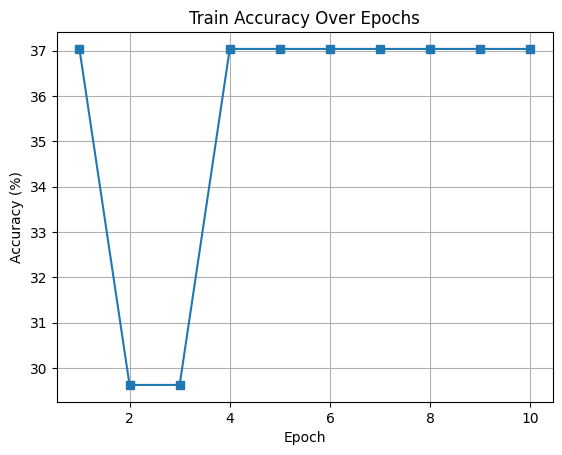

In [ ]:
# Track epoch loss and accuracy for plotting
epoch_losses = []
epoch_accuracies = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# which model to use
model_dict = {
    'VGG16Classifier': {
        'path': "/content/drive/My Drive/Frechette Lab/VGG16Classifier_weights.pt",
        'model': VGG16Classifier(num_conv_layers_to_use=2).to(device)
    }
}

WEIGHTS_PATH = model_dict['VGG16Classifier']['path']
model = model_dict['VGG16Classifier']['model']

# Load saved weights
try:
    state_dict = torch.load(WEIGHTS_PATH, map_location=device)
    model.load_state_dict(state_dict)
    print(f"Successfully loaded model weights from {WEIGHTS_PATH}")
except FileNotFoundError:
    print(f"Warning: Weights file not found at {WEIGHTS_PATH}. Starting training with random initialization.")
except RuntimeError as e:
    print(f"Error loading state_dict: {e}")
    print("This might happen if the model architecture does not match the saved weights.")
    print("Starting training with random initialization.")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#TEST_PATH = glob.glob('/content/drive/My Drive/Frechette Lab/test_dataset/*/*')
#test_output = '/content/drive/My Drive/Frechette Lab/test_processed_dataset'
#for image in TEST_PATH:
    #reprocess(image, output = test_output)
#test_dataset = datasets.ImageFolder(root=test_output, transform=transforms.ToTensor())
test_dataset = datasets.ImageFolder(root='/content/drive/My Drive/Frechette Lab/test_dataset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print("Starting training...")
for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)

    #evaluate
    accuracy = evaluate(model, train_loader)
    epoch_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%")


print(f"Test Accuracy: {evaluate(model, test_loader)}")
print("Training finished.")

# Save updated weights
try:
    torch.save(model.state_dict(), WEIGHTS_PATH)
    print(f"Successfully saved updated model weights to {WEIGHTS_PATH}")
except Exception as e:
    print(f"Error saving model weights: {e}")

epochs = range(1, len(epoch_losses) + 1)

#Plot the loss over epochs
plt.figure()
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.show()

#Plot the accuracy over epochs
plt.figure()
plt.plot(range(1, len(epoch_accuracies) + 1), [a for a in epoch_accuracies], marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train Accuracy Over Epochs")
plt.grid(True)
plt.show()